# <b><u> Project Title : Sentiment Analysis : Predicting sentiment of COVID-19 tweets</u></b>

In [1]:
import pandas as pd
import unidecode
import re
import string
import math

# Just for my peace of mind
from tqdm import tqdm

from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost

In [2]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# removing negating words
stop_words.remove("not")
for word in list(stop_words):
    if word[-2:] == "'t":
        stop_words.remove(word)

punctuations = string.punctuation.replace("'", "")

# Later use hastags for computing different TF-IDF
punctuations = punctuations.replace("#", "")

In [3]:
df = pd.read_csv("Coronavirus Tweets.csv", engine= "python", encoding="ISO-8859-1")

In [4]:
# No easy way than to code a library to clean the available data, as it deals with all edge cases 
# Ignoring "Location" column after trying to clean it with [GeoText, locationtagger] libraries
# df["Location"].value_counts()[:10].plot(kind="bar", ylabel = "", title="Top 10 Countries", figsize=(15, 5));

df.drop("Location", axis=1, inplace=True)

In [5]:
df["OriginalTweet"] = [i.replace("Â", "") for i in df["OriginalTweet"]]
df["OriginalTweet"] = [unidecode.unidecode(i) for i in df["OriginalTweet"]]

### Checking if same "UserName" occuring more than once 

In [6]:
[x for x,y in zip(df["UserName"].value_counts().keys(), df["UserName"].value_counts().values) if y>1]

[]

### Overview of Sentiments 

In [7]:
df["Sentiment_2"] = df["Sentiment"].replace({"Extremely Positive": "Positive", "Extremely Negative": "Negative"})

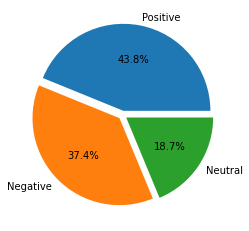

In [8]:
df["Sentiment_2"].value_counts().plot(kind="pie", 
                                      autopct='%0.1f%%', 
                                      explode=[0.05]*len(df["Sentiment_2"].value_counts()), 
                                      ylabel = "");

In [9]:
def preprocess(old_string):
    '''
    Removing 
    1. @ Tags
    2. Links
    3. Standalone Digits (Since I want "covid19" as one of the features)
    '''
    
    new_string = old_string.lower()
    new_string = re.sub("(@[\w]+)|(\w+:\/\/\S+)|(\s\d+\s)", " ", new_string)
    
    # Lemmatization
    new_string = lemmatizer.lemmatize(new_string)
    
    # removing stop words
    new_string = " ".join([word for word in new_string.split() if word not in stop_words])
    
    # Removing punctuations
    # new_string = re.sub("[^\w\s]", " ", new_string)
    # Not the most efficient way, but a necessary evil considering I want to keep contractions such as shouldn't and don't
    for element in new_string:
        if element in punctuations:
            new_string = new_string.replace(element, "")
    new_string = new_string.replace("_", "")
    
    # Removing digits
    new_string = re.sub("(\s\d+\s)", " ", new_string)
    
    # Removing extra spaces
    new_string = " ".join(new_string.split())
    
    return new_string

In [10]:
df["ProcessedTweet"] = df["OriginalTweet"].apply(preprocess)

In [11]:
# removing all the rows where the "ProcessedTweet"s are empty
df.drop(df[df["ProcessedTweet"]==""].index, inplace=True)

### Creating TF-IDF [(Term Frequency - Inverse Document Frequency)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

$$TF = \frac{Count(word)\space in\space sentence}{Sum(words)\space in\space sentence}$$

$$IDF = \log(\frac{Count(Sentence)}{Count(Sentence)\space with\space word})$$

In [12]:
# Don NOT execute this unless you have upwards of 62hours to spare


# # Creating IDF dict for each word

# all_words = " ".join(df["ProcessedTweet"].values).strip().split()
# no_of_sent = len(df["ProcessedTweet"])

# idf_dict = {word:0 for word in set(all_words)}

# for sent in tqdm(df["ProcessedTweet"]):
#     for word in idf_dict.keys():
#         if word in sent.split():
#             idf_dict[word] += 1
# # Finalizing IDF dict
# idf_dict = {key:math.log10(no_of_sent/value) for key, value in idf_dict.items()}

# # Creating Dataframe for tf_idf
# tf_idf_df = pd.DataFrame(columns=[word for word in idf_dict.keys()])

# for idx, sent in tqdm(enumerate(df["ProcessedTweet"])):
#     tf_idf_df.append(pd.Series(), ignore_index=True)
#     for word in idf_dict.keys():
#         tf_idf_df.loc[idx, word] = (sent.split().count(word)/len(sent.split()))*idf_dict[word]

##### Test Train Split

In [13]:
# To avoid any data leakage, lets split the data first and then extract features.

X_train, X_test, y_train, y_test = train_test_split(df["ProcessedTweet"], 
#                                                     df["Sentiment"],
                                                    df["Sentiment_2"],
                                                    test_size = 0.15, random_state = 420)

In [14]:
# Before prunning since our dataset is limited and testing is maximum potential is possible
all_words = set(" ".join(X_train.values).strip().split())
vocab = {word:idx for idx, word in enumerate(all_words)}

# tf_idf_vect = TfidfVectorizer(lowercase=False, min_df=0, max_df=50)
tf_idf_vect = TfidfVectorizer(lowercase=False, vocabulary=vocab)

In [15]:
tf_idf_train = tf_idf_vect.fit_transform(X_train)
tf_idf_test = tf_idf_vect.transform(X_test)

Lets build models and compare their performance based on f1 score which considers both accuracy and precision.

In [16]:
models = {}

In [17]:
def models_reviewer(models, X_test, y_test):
    '''
    models : dictionary with key as name of the model and value as model itself
    '''
    for model in models.items():
        
        y_pred = model[1].predict(X_test)
        # precision = precision_score(y_test, y_pred, average="weighted")
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"\t\t\t----- {model[0]} -----\n")
        print(classification_report(y_test, y_pred), end="\n\n")
#         print(classification_report(y_test, y_pred))
#         print(f"accuracy = {accuracy}", end="\n\n")

### [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)
Usually considered to be a baseline for Text Classification problems

In [18]:
MNB_params = {"alpha": [0, 0.4, 0.6, 1]}
grid_MNB = GridSearchCV(MultinomialNB(), 
                        param_grid=MNB_params, 
                        scoring="f1_weighted", 
                        verbose=2,
                        n_jobs=-1)
model = grid_MNB.fit(tf_idf_train, y_train)
models["Multinomial Naive Bayes"] = model

Fitting 5 folds for each of 4 candidates, totalling 20 fits


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


### [Logistic Regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

In [19]:
lr_params = {"C": [0.4, 0.6, 1]}
grid_lr = GridSearchCV(LogisticRegression(verbose=1, n_jobs=-1,), 
                       param_grid=lr_params, 
                       scoring="f1_weighted", 
                       verbose=2,
                       n_jobs=-1)
model = grid_lr.fit(tf_idf_train, y_train)
models["Logistic Regression"] = model

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s finished


### [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

In [20]:
SVC_params = {"C": [0.4, 0.6, 1], 
              "kernel":['rbf', 'sigmoid', 'poly'],
              "degree":[3, 4]}
grid_SVC = GridSearchCV(SVC(verbose=1,), 
                       param_grid=SVC_params, 
                       scoring="f1_weighted", 
                       verbose=2,
                       n_jobs=-1)
model = grid_SVC.fit(tf_idf_train, y_train)
models["Support Vector Classification"] = model

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LibSVM]

### [Random Forest]()

In [21]:
RF_params = {"criterion": ["gini", "entropy"], 
              "n_estimators":[10, 100, 400, 700],
              "max_depth":[3, 7]}
grid_RF = GridSearchCV(RandomForestClassifier(verbose=1, n_jobs=-1), 
                       param_grid=RF_params, 
                       scoring="f1_weighted", 
                       verbose=2,
                       n_jobs=-1)
model = grid_SVC.fit(tf_idf_train, y_train)
models["Random Forest Classifier"] = model

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LibSVM]

### [Gradient Boosting](https://xgboost.readthedocs.io/en/stable/python/python_intro.html)

In [22]:
xgb_params = {"eta": [0.01, 0.1, 0.2, 0.3], #Learning Rate
              "max_depth":[3, 5, 8, 10],
              "min_child_weight ":[1, 7]}
grid_xgb = GridSearchCV(xgboost.XGBClassifier(verbosity=2, eval_metric="merror"), 
                       param_grid=xgb_params, 
                       scoring="f1_weighted", 
                       verbose=2,
                       n_jobs=-1)
model = grid_xgb.fit(tf_idf_train, y_train)
models["Extreme Gradient Boosting Classifier"] = model

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[04:33:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[04:33:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[04:33:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[04:33:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[04:33:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[04:33:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tre

[04:34:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[04:34:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10
[04:34:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[04:34:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[04:34:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[04:34:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_d

[04:34:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[04:34:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[04:34:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[04:34:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[04:34:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[04:34:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_d

[04:35:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[04:35:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[04:35:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[04:35:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[04:35:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[04:35:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_de

[04:35:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[04:35:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[04:35:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[04:35:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[04:35:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[04:35:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_de

[04:35:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[04:35:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[04:35:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[04:35:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[04:35:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[04:35:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_dep

[04:36:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[04:36:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[04:36:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[04:36:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[04:36:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[04:36:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth

### [KNN]()

In [23]:
# Usually scaling is done, but since we are using tf_idf, it is not needed

# min_max_scaler = MinMaxScaler()

# tf_idf_scaled_train = min_max_scaler.fit_transform(tf_idf_train)
# tf_idf_scaled_test = min_max_scaler.transform(tf_idf_test)

In [24]:
knn_params = {"metric": ["minkowski", "cosine"]}
grid_knn = GridSearchCV(KNeighborsClassifier( n_jobs=-1), 
                       param_grid=knn_params, 
                       scoring="f1_weighted", 
                       verbose=2,
                       n_jobs=-1)
model = grid_knn.fit(tf_idf_train, y_train)
models["KNeighbors Classifier"] = model

Fitting 5 folds for each of 2 candidates, totalling 10 fits


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan]
  category=UserWarning,


In [25]:
models_reviewer(models, tf_idf_test, y_test)

			----- Multinomial Naive Bayes -----

              precision    recall  f1-score   support

    Negative       0.62      0.67      0.64      2269
     Neutral       0.63      0.25      0.36      1161
    Positive       0.63      0.75      0.68      2741

    accuracy                           0.63      6171
   macro avg       0.63      0.56      0.56      6171
weighted avg       0.63      0.63      0.61      6171


			----- Logistic Regression -----

              precision    recall  f1-score   support

    Negative       0.79      0.81      0.80      2269
     Neutral       0.76      0.61      0.68      1161
    Positive       0.81      0.86      0.84      2741

    accuracy                           0.80      6171
   macro avg       0.79      0.76      0.77      6171
weighted avg       0.79      0.80      0.79      6171


			----- Support Vector Classification -----

              precision    recall  f1-score   support

    Negative       0.79      0.80      0.79      2269
     